In [4]:
# Data
import numpy as np
with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [19]:
# Model
import impl.loss as loss_fun
import impl.layer as l
# import impl.utils as util
import impl.NN as nn

class LSTM(nn.NN):

    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'valid':[], 'test':[]}
        super().__init__(D, D, H, None, None, loss='cross_ent', nonlin='relu')

    def _init_model(self, D, C, H):
        Z = H + D
        m = dict(
            Wf=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wi=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wc=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wo=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(D / 2.),
            bf=np.zeros((1, H)),
            bi=np.zeros((1, H)),
            bc=np.zeros((1, H)),
            bo=np.zeros((1, H)),
            by=np.zeros((1, D)))

        self.model = []
        for l in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return (np.zeros((1, self.H)), np.zeros((1, self.H)))

    def forward(self, X, h, m):
        Wf, Wi, Wc, Wo, Wy = m['Wf'], m['Wi'], m['Wc'], m['Wo'], m['Wy']
        bf, bi, bc, bo, by = m['bf'], m['bi'], m['bc'], m['bo'], m['by']

        h_old, c_old = h
        X_one_hot = X.copy()

        X = np.column_stack((h_old, X_one_hot))

        hf, hf_cache = l.fc_forward(X, Wf, bf)
        hf, hf_sigm_cache = l.sigmoid_forward(hf)

        hi, hi_cache = l.fc_forward(X, Wi, bi)
        hi, hi_sigm_cache = l.sigmoid_forward(hi)

        ho, ho_cache = l.fc_forward(X, Wo, bo)
        ho, ho_sigm_cache = l.sigmoid_forward(ho)

        hc, hc_cache = l.fc_forward(X, Wc, bc)
        hc, hc_tanh_cache = l.tanh_forward(hc)

        c = hf * c_old + hi * hc
        c, c_tanh_cache = l.tanh_forward(c)

        h = ho * c

        y, y_cache = l.fc_forward(h, Wy, by)
        h = (h, c)

        cache = (
            X, hf, hi, ho, hc, hf_cache, hf_sigm_cache, hi_cache, hi_sigm_cache, ho_cache,
            ho_sigm_cache, hc_cache, hc_tanh_cache, c_old, c, c_tanh_cache, y_cache
        )
        

        return y, h, cache


    def backward(self, dy, dh, cache):
        X, hf, hi, ho, hc, hf_cache, hf_sigm_cache, hi_cache, hi_sigm_cache, ho_cache, ho_sigm_cache, hc_cache, hc_tanh_cache, c_old, c, c_tanh_cache, y_cache = cache
        dh_next, dc_next = dh

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next

        dho = c * dh
        dho = l.sigmoid_backward(dho, ho_sigm_cache)

        dc = ho * dh
        dc = l.tanh_backward(dc, c_tanh_cache)
        dc = dc + dc_next

        dhf = c_old * dc
        dhf = l.sigmoid_backward(dhf, hf_sigm_cache)

        dhi = hc * dc
        dhi = l.sigmoid_backward(dhi, hi_sigm_cache)

        dhc = hi * dc
        dhc = l.tanh_backward(dhc, hc_tanh_cache)

        dXo, dWo, dbo = l.fc_backward(dho, ho_cache)
        dXc, dWc, dbc = l.fc_backward(dhc, hc_cache)
        dXi, dWi, dbi = l.fc_backward(dhi, hi_cache)
        dXf, dWf, dbf = l.fc_backward(dhf, hf_cache)

        dX = dXo + dXc + dXi + dXf
        dh_next = dX[:, :self.H]
        dc_next = hf * dc

        dX = dX[:, self.H:]
        dh = (dh_next, dc_next)

        grad = dict(Wf=dWf, Wi=dWi, Wc=dWc, Wo=dWo, Wy=dWy, bf=dbf, bi=dbi, bc=dbc, bo=dbo, by=dby)

        return dX, dh, grad
            
    def train_forward(self, X_train, h):
        ys, caches = [], []
#         h_init = h.copy()
        h, c = h
        h_init = (h.copy(), c.copy())
        h = []
        for l in range(self.L):
            h.append(h_init)
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
                caches[l].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += loss_fun.cross_entropy(self.model[0], y_pred, y, lam=0)/ y_train.shape[0]
#             loss += loss_fun.cross_entropy(y_pred, y)/ y_train.shape[0]
            dy = loss_fun.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for l in range(self.L):
            dh.append((np.zeros((1, self.H)), np.zeros((1, self.H))))
            grad.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for l in reversed(range(self.L)):
                dX, dh[l], grad[l] = self.backward(dX, dh[l], caches[l][t])
                for k in grad[0].keys():
                    grads[l][k] += grad[l][k]
                
        return dX, grads
    
    def test(self, X_seed, h, size=100):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
#         h_init = h.copy()
        h, c = h
        h_init = (h.copy(), c.copy())
        h = []
        for _ in range(self.L):
            h.append(h_init)

        for _ in range(size - 1):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(y, h[layer], self.model[layer])
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [20]:
# import numpy as np
# import impl.utils as util
# import impl.constant as c
# import copy
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha=0.001, mb_size=256, n_iter=2000, print_after=100):
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    idx = 0
    state = nn.initial_state()
    loss = np.log(len(set(X_train)))
#     smooth_loss = -np.log(1.0 / len(set(X_train)))
    eps = 1e-8
    
    M, R = [], []
    for _ in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        
    beta1 = .9
    beta2 = .999

    for iter in range(1, n_iter + 1):

        if idx >= len(minibatches):
            idx = 0
            state = nn.initial_state()

        X_mini, y_mini = minibatches[idx]
        idx += 1

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
#             print('Iter-{} loss: {:.4f}'.format(iter, smooth_loss))
            sample = nn.test(X_mini[0], state)
            print(sample)

        ys, caches = nn.train_forward(X_mini, state)
        loss, dys = nn.loss_function(y_mini, ys)
        dX, grads = nn.train_backward(dys, caches)
#         smooth_loss = 0.999 * smooth_loss + 0.001 * loss
        nn.losses['train'].append(loss)

        for layer in range(nn.L):
            for k in grads[0].keys(): #key, value: items
                M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
    
    return nn

In [33]:
vocab_size = len(char_to_idx)

# hyper parameters
time_step = 100 # width
num_layers = 1 # depth
n_iter = 13000 # epochs
alpha = 1e-3 # learning_rate
print_after = n_iter//10 # print training loss, valid, and test
H = 64 # num_hidden_units in hidden layer

In [34]:
net = LSTM(D=vocab_size, H=H, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-1300 loss: 2.3351
 som o ean Chal ffr. Grelieo7,e yin dalas doxnulWos SisileplessSilld u The hed tit To tha es tin. Gf
Iter-2600 loss: 2.2721
t6–Wy tn m-Aasrah-anolslas3 inglapatan Jancan :r the er thivekm winsth ra, Col, ind ar thek7 1ur an 
Iter-3900 loss: 1.9744
tSe fian 47 forocthy Oh the soked en text w oned In wharand The Kounst rly Apan Griscre War toun ory
Iter-5200 loss: 2.2108
rs 1ang Eangens counl's the inste at ond fexpann, 19th 6 ast's copmeda e mints iold din"1x ant esof 
Iter-6500 loss: 1.6968
mpy rf fis inly. inoth-geothert ingitht wald's and ofe apeas icest-rionu, win catestil Apagstaila. J
Iter-7800 loss: 2.0340
 JTope cirt ly. Naipryss as Nry sice Jaed; sulererommomeoftvol on om Thestrtecesterarke 12 98d 201 J
Iter-9100 loss: 1.7426
r(of echethe coly The whist thicol thild fild Wor on sot the Imeditallere fortomy Iminly Coru an Cim
Iter-10400 loss: 1.8868
 andivectorgtof 196 The Acthud Che so erthins, Eape ")ptod untrert. die sod and hochal ty ercol Sonk
Iter-11

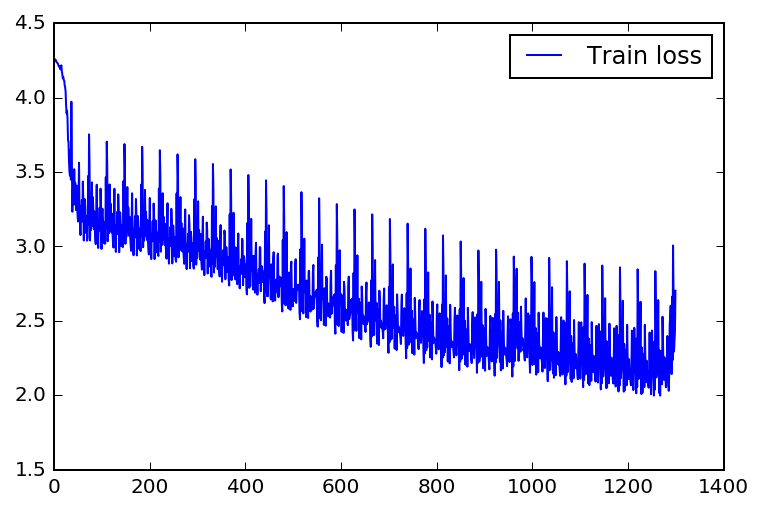

In [32]:
# Display the learning curve and losses for training, validation, and testing
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
# matplot.plot(losses_tx2['valid'], label='Valid loss')
plt.legend()
# _ = plt.ylim()